In [1]:
import re
import nltk
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Activation,Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Flatten,GlobalMaxPooling1D,Conv1D, Embedding, LSTM

In [4]:
df = pd.read_csv("Dataset/IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [6]:
df.isnull().sum()

review       0
sentiment    0
dtype: int64

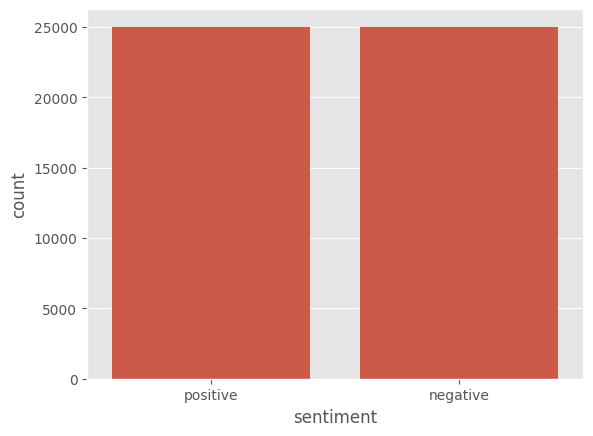

In [7]:
import seaborn as sns
plt.style.use("ggplot")
sns.countplot(data = df, x = df["sentiment"])
plt.show()

In [8]:
df["sentiment"].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

In [9]:
df["review"][2]

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

In [10]:
stopwords_list = set(stopwords.words('english'))


TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)
    

class CustomPreprocess():

    def __init__(self):
        pass

    def preprocess_text(self,sen):
        sen = sen.lower()
        
        # Remove html tags
        sentence = remove_tags(sen)

        # Remove punctuations and numbers
        sentence = re.sub('[^a-zA-Z]', ' ', sentence)
        
        # Single character removal
        sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

        # Remove multiple spaces
        sentence = re.sub(r'\s+', ' ', sentence)
        
        # Remove Stopwords
        pattern = re.compile(r'\b(' + r'|'.join(stopwords_list) + r')\b\s*')
        sentence = pattern.sub('', sentence)
        
        return sentence

In [11]:
custom = CustomPreprocess()
custom.preprocess_text("I thought this was a wonderful way to spend time on a too hot summer weekend")

'thought wonderful way spend time hot summer weekend'

In [12]:
x = []
sentences = list(df['review'])
for sen in sentences:
    x.append(custom.preprocess_text(sen))

In [13]:
y = df['sentiment']
sentiment_map = {'negative' : 0, 'positive': 1}
y = np.array(y.map(sentiment_map))
y[:15]

array([1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1], dtype=int64)

In [14]:
x_train, x_test, y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

In [15]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

In [16]:
import io
import json
tokenizer_json = tokenizer.to_json()

with io.open("tokenizer.json", 'w', encoding = "utf-8") as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii = False))

In [17]:
vocab_length = len(tokenizer.word_index)+1
vocab_length

92394

In [18]:
maxlen = 100

x_train = pad_sequences(x_train, padding='post', maxlen=maxlen)
x_test = pad_sequences(x_test, padding='post', maxlen=maxlen)

In [20]:
embedding_dict = dict()
glove_file = open("Dataset/glove.6B.100d.txt", encoding = 'utf8')
embeddings_dictionary = dict()
for line in glove_file:
    records = line.split()
    words = records[0]
    vector_dimensions = np.asarray(records[1:], dtype = 'float32')
    embeddings_dictionary[words] = vector_dimensions
glove_file.close()

In [21]:
print(list(tokenizer.word_index.items())[:15])

[('movie', 1), ('film', 2), ('one', 3), ('like', 4), ('good', 5), ('time', 6), ('even', 7), ('would', 8), ('story', 9), ('really', 10), ('see', 11), ('well', 12), ('much', 13), ('bad', 14), ('get', 15)]


In [22]:
embeddings_dictionary.get('film')

array([ 0.19916 , -0.049702,  0.24579 , -0.32281 ,  0.89768 , -0.1278  ,
       -0.49506 ,  0.20814 , -0.20046 , -0.20604 ,  0.038292, -0.67277 ,
       -0.12689 , -0.18766 , -0.10277 ,  0.73128 ,  0.82408 ,  0.087288,
        0.69255 ,  1.3107  ,  0.49113 , -0.38097 ,  0.24338 , -0.27813 ,
        0.62506 ,  0.35978 ,  0.42041 , -0.24529 ,  0.14861 , -0.26726 ,
       -0.56262 ,  0.63843 , -0.54153 ,  0.36537 ,  0.20545 , -0.16604 ,
        0.72434 ,  0.29961 , -0.42501 , -0.35932 , -0.089288,  0.48752 ,
       -1.0927  ,  0.88818 ,  0.89941 , -0.7541  , -0.35492 , -0.76396 ,
        0.27468 ,  0.2757  , -0.48152 , -0.41399 ,  0.64489 ,  1.148   ,
       -0.29131 , -2.9387  , -0.83162 ,  0.95586 ,  1.1623  , -0.42502 ,
        0.15486 ,  2.2326  , -0.31339 , -0.030228,  0.79802 , -0.41302 ,
        0.72885 ,  0.7296  , -0.31909 ,  0.8956  ,  0.34625 ,  0.2923  ,
        0.40056 ,  0.78985 , -0.43999 ,  0.24698 , -0.46548 ,  0.055886,
       -0.62603 , -0.036487, -0.65429 ,  0.10563 , 

In [23]:
embeddings_dictionary['film']

array([ 0.19916 , -0.049702,  0.24579 , -0.32281 ,  0.89768 , -0.1278  ,
       -0.49506 ,  0.20814 , -0.20046 , -0.20604 ,  0.038292, -0.67277 ,
       -0.12689 , -0.18766 , -0.10277 ,  0.73128 ,  0.82408 ,  0.087288,
        0.69255 ,  1.3107  ,  0.49113 , -0.38097 ,  0.24338 , -0.27813 ,
        0.62506 ,  0.35978 ,  0.42041 , -0.24529 ,  0.14861 , -0.26726 ,
       -0.56262 ,  0.63843 , -0.54153 ,  0.36537 ,  0.20545 , -0.16604 ,
        0.72434 ,  0.29961 , -0.42501 , -0.35932 , -0.089288,  0.48752 ,
       -1.0927  ,  0.88818 ,  0.89941 , -0.7541  , -0.35492 , -0.76396 ,
        0.27468 ,  0.2757  , -0.48152 , -0.41399 ,  0.64489 ,  1.148   ,
       -0.29131 , -2.9387  , -0.83162 ,  0.95586 ,  1.1623  , -0.42502 ,
        0.15486 ,  2.2326  , -0.31339 , -0.030228,  0.79802 , -0.41302 ,
        0.72885 ,  0.7296  , -0.31909 ,  0.8956  ,  0.34625 ,  0.2923  ,
        0.40056 ,  0.78985 , -0.43999 ,  0.24698 , -0.46548 ,  0.055886,
       -0.62603 , -0.036487, -0.65429 ,  0.10563 , 

In [24]:
embedding_matrix = np.zeros((vocab_length, 100)) #100
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [25]:
embedding_matrix.shape

(92394, 100)

In [26]:
snn = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights = [embedding_matrix], input_length = maxlen, trainable = False)
snn.add(embedding_layer)
snn.add(Flatten())
snn.add(Dense(16, activation='relu'))
snn.add(Dense(1,activation = 'sigmoid'))

C:\Users\ayush\AppData\Roaming\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [27]:
snn.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])
snn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │       9,239,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,239,400 (35.25 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,239,400 (35.25 MB)

In [28]:
history_snn = snn.fit(x_train,y_train, batch_size=128, epochs = 10, 
                      verbose=1, validation_split =0.2)

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.6705 - loss: 0.5997 - val_accuracy: 0.7600 - val_loss: 0.4949
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8117 - loss: 0.4173 - val_accuracy: 0.7650 - val_loss: 0.4945
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8473 - loss: 0.3573 - val_accuracy: 0.7638 - val_loss: 0.5043
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8733 - loss: 0.3082 - val_accuracy: 0.7577 - val_loss: 0.5257
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8984 - loss: 0.2616 - val_accuracy: 0.7561 - val_loss: 0.5686
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9211 - loss: 0.2133 - val_accuracy: 0.7479 - val_loss: 0.6345
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9408 - loss: 0.1735 - val_accuracy: 0.7465 - val_loss: 0.6761
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9536 - loss: 0.1413 - val_accuracy: 0

In [30]:
result = snn.evaluate(x_test,y_test, verbose = 1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7197 - loss: 0.9731


In [31]:
print("Test Accuracy:", result[1])
print("Test Loss:", result[0])

Test Accuracy: 0.7214999794960022
Test Loss: 0.9836999177932739


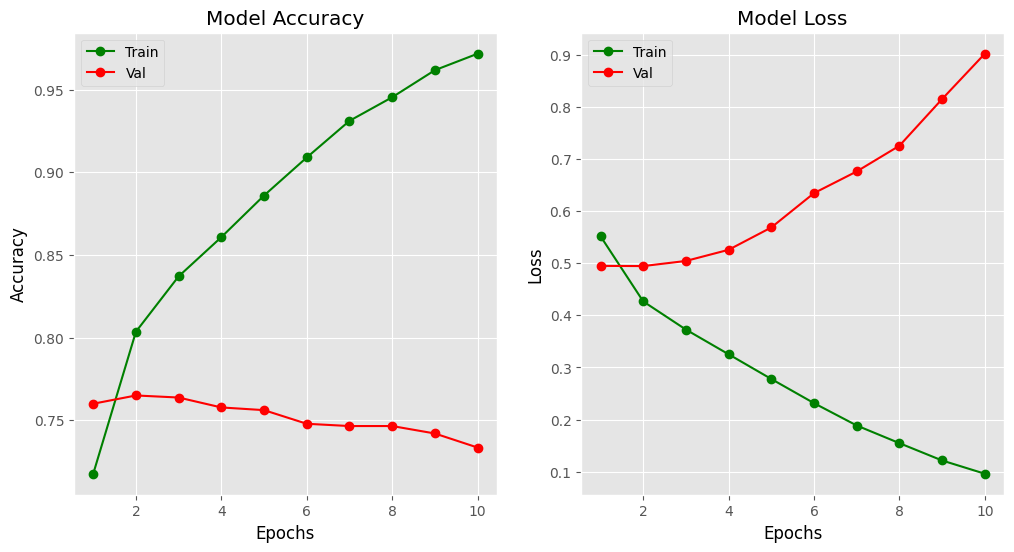

In [32]:
plt.figure(figsize=(12,6))
epochs = range(1,11)
plt.subplot(1,2,1)
plt.plot(epochs,history_snn.history["accuracy"],color = 'green', marker = 'o')
plt.plot(epochs,history_snn.history["val_accuracy"],color = 'red', marker = 'o')
plt.title("Model Accuracy")
plt.xlabel("Epochs",color = 'black')
plt.ylabel("Accuracy",color = 'black')
plt.legend(['Train','Val'],loc = "upper left")

plt.subplot(1,2,2)
plt.plot(epochs,history_snn.history["loss"],color = 'green', marker = 'o')
plt.plot(epochs,history_snn.history["val_loss"],color = 'red', marker = 'o')
plt.title("Model Loss")
plt.xlabel("Epochs",color = 'black')
plt.ylabel("Loss",color = 'black')
plt.legend(['Train','Val'],loc = "upper left")

plt.show()

In [33]:
from keras.layers import Conv1D
cnn = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights = [embedding_matrix], input_length = maxlen, trainable = False)
cnn.add(embedding_layer)
cnn.add(Conv1D(128,5,activation = 'relu'))
cnn.add(Dropout(0.2))

cnn.add(Conv1D(256,5,activation = 'relu'))
cnn.add(GlobalMaxPooling1D())

cnn.add(Dense(1,activation = 'sigmoid'))

In [34]:
cnn.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])
cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │       9,239,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,239,400 (35.25 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,239,400 (35.25 MB)

In [35]:
history_cnn = cnn.fit(x_train,y_train, batch_size=128, epochs = 10, 
                      verbose=1, validation_split =0.2)

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 51s 173ms/step - accuracy: 0.6632 - loss: 0.5959 - val_accuracy: 0.8186 - val_loss: 0.4054
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 42s 166ms/step - accuracy: 0.8247 - loss: 0.3902 - val_accuracy: 0.8425 - val_loss: 0.3590
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 164ms/step - accuracy: 0.8520 - loss: 0.3440 - val_accuracy: 0.8349 - val_loss: 0.3615
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 164ms/step - accuracy: 0.8733 - loss: 0.3012 - val_accuracy: 0.8360 - val_loss: 0.3673
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.8914 - loss: 0.2642 - val_accuracy: 0.8518 - val_loss: 0.3392
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 42s 166ms/step - accuracy: 0.9166 - loss: 0.2158 - val_accuracy: 0.8439 - val_loss: 0.3686
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 42s 167ms/step - accuracy: 0.9243 - loss: 0.1890 - val_accuracy: 0.8515 - val_loss: 0.3641
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 42s 167ms/step - accuracy: 0.9442 - loss: 0

In [36]:
cnn_result = cnn.evaluate(x_test,y_test, verbose = 1)
print("Test Accuracy:", cnn_result[1])
print("Test Loss:", cnn_result[0])

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.8505 - loss: 0.4164
Test Accuracy: 0.8485999703407288
Test Loss: 0.4177946150302887


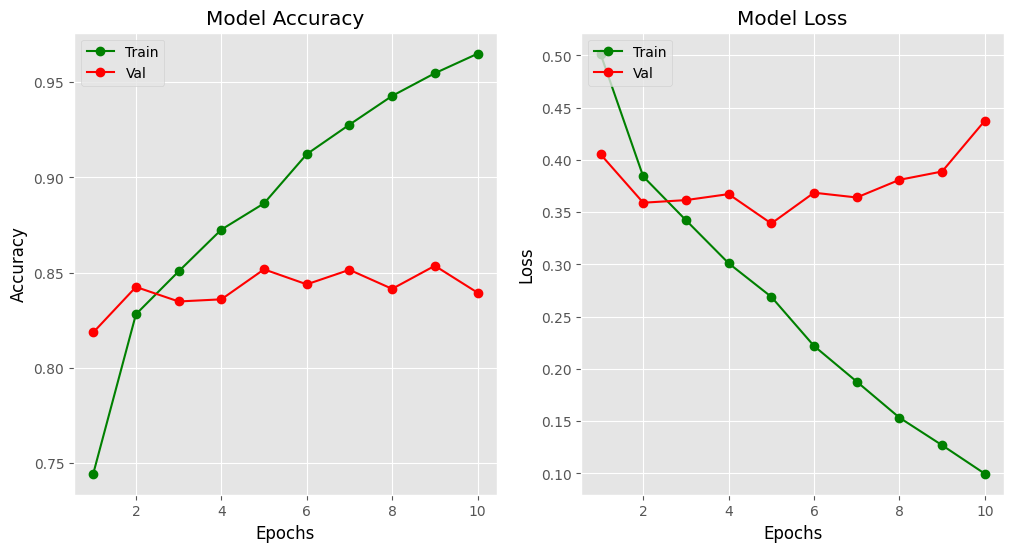

In [37]:
plt.figure(figsize=(12,6))
epochs = range(1,11)
plt.subplot(1,2,1)
plt.plot(epochs,history_cnn.history["accuracy"],color = 'green', marker = 'o')
plt.plot(epochs,history_cnn.history["val_accuracy"],color = 'red', marker = 'o')
plt.title("Model Accuracy")
plt.xlabel("Epochs",color = 'black')
plt.ylabel("Accuracy",color = 'black')
plt.legend(['Train','Val'],loc = "upper left")

plt.subplot(1,2,2)
plt.plot(epochs,history_cnn.history["loss"],color = 'green', marker = 'o')
plt.plot(epochs,history_cnn.history["val_loss"],color = 'red', marker = 'o')
plt.title("Model Loss")
plt.xlabel("Epochs",color = 'black')
plt.ylabel("Loss",color = 'black')
plt.legend(['Train','Val'],loc = "upper left")

plt.show()

In [38]:
lstm = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights = [embedding_matrix], input_length = maxlen, trainable = False)
lstm.add(embedding_layer)
lstm.add(LSTM(128)) #return_sequences=True
# lstm.add(LSTM(64, return_sequences=True))

# lstm.add(Dropout(0.2))
# lstm.add(LSTM(32))


# cnn.add(Conv1D(256,5,activation = 'relu'))
# cnn.add(GlobalMaxPooling1D())

lstm.add(Dense(1,activation = 'sigmoid'))

In [39]:
lstm.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])
lstm.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │       9,239,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,239,400 (35.25 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,239,400 (35.25 MB)

In [40]:
history_lstm = lstm.fit(x_train,y_train, batch_size=128, epochs = 10, 
                      verbose=1, validation_split =0.2)

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 101s 386ms/step - accuracy: 0.6960 - loss: 0.5678 - val_accuracy: 0.8092 - val_loss: 0.4292
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 98s 392ms/step - accuracy: 0.8079 - loss: 0.4269 - val_accuracy: 0.8334 - val_loss: 0.3835
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 96s 386ms/step - accuracy: 0.8424 - loss: 0.3751 - val_accuracy: 0.8330 - val_loss: 0.3815
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 98s 391ms/step - accuracy: 0.8503 - loss: 0.3540 - val_accuracy: 0.8577 - val_loss: 0.3317
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 99s 394ms/step - accuracy: 0.8612 - loss: 0.3233 - val_accuracy: 0.8438 - val_loss: 0.3675
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 99s 395ms/step - accuracy: 0.8716 - loss: 0.3146 - val_accuracy: 0.8651 - val_loss: 0.3170
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 101s 404ms/step - accuracy: 0.8820 - loss: 0.2831 - val_accuracy: 0.8660 - val_loss: 0.3197
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 100s 400ms/step - accuracy: 0.8861 - loss

In [41]:
lstm_result = lstm.evaluate(x_test,y_test, verbose = 1)
print("Test Accuracy:", lstm_result[1])
print("Test Loss:", lstm_result[0])

313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 89ms/step - accuracy: 0.8618 - loss: 0.3474
Test Accuracy: 0.8614000082015991
Test Loss: 0.34612664580345154


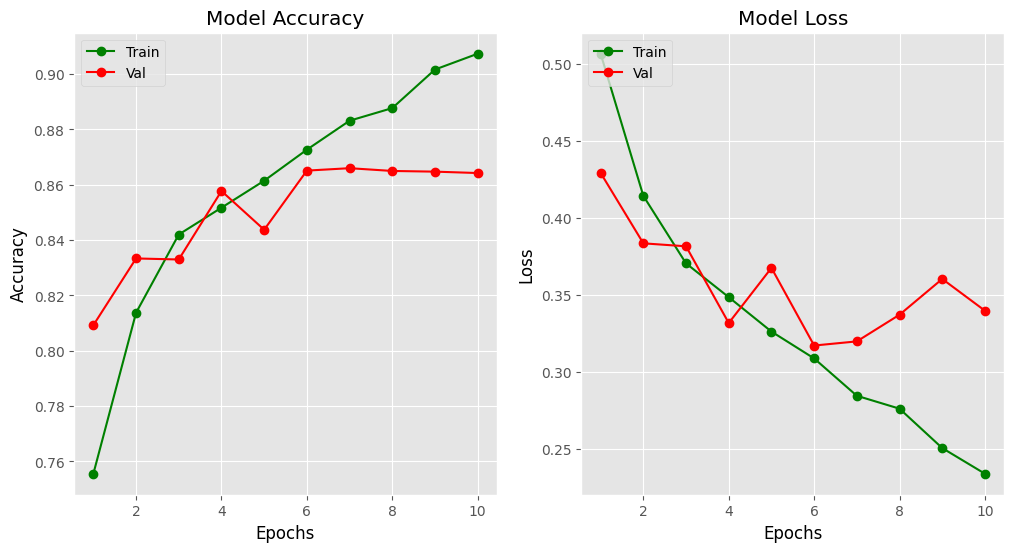

In [42]:
plt.figure(figsize=(12,6))
epochs = range(1, 11)
plt.subplot(1,2,1)
plt.plot(epochs,history_lstm.history["accuracy"],color = 'green', marker = 'o')
plt.plot(epochs,history_lstm.history["val_accuracy"],color = 'red', marker = 'o')
plt.title("Model Accuracy")
plt.xlabel("Epochs",color = 'black')
plt.ylabel("Accuracy",color = 'black')
plt.legend(['Train','Val'],loc = "upper left")

plt.subplot(1,2,2)
plt.plot(epochs,history_lstm.history["loss"],color = 'green', marker = 'o')
plt.plot(epochs,history_lstm.history["val_loss"],color = 'red', marker = 'o')
plt.title("Model Loss")
plt.xlabel("Epochs",color = 'black')
plt.ylabel("Loss",color = 'black')
plt.legend(['Train','Val'],loc = "upper left")

plt.show()

In [43]:
lstm.save("sentiment_classifier2.h5")